In [2]:
import psutil
psutil.cpu_count(logical=True)

12

In [1]:
import fdtd as oNN
import config as cfg
import numpy as np


In [2]:
def Init(sources):

    oNN.set_backend(cfg.backend)

    grid = oNN.Grid(
        shape=(400, 400, 1), # 优化区域为6.25um * 6.25um
        grid_spacing=25e-9, # 25nm
        permittivity=1.0,
    )

    grid[0:10, :, :] = oNN.PML(name="pml_xlow")
    grid[-10:, :, :] = oNN.PML(name="pml_xhigh")
    grid[:, 0:10, :] = oNN.PML(name="pml_ylow")
    grid[:, -10:, :] = oNN.PML(name="pml_yhigh")

    port_slices = [
        slice(82, 102), slice(106, 126), slice(130, 150), slice(154, 174), slice(178, 198), 
        slice(202, 222), slice(226, 246), slice(250, 270), slice(274, 294), slice(298, 318)
    ]

    for i, (port_slice, source) in enumerate(zip(port_slices, sources)):
        grid[25, port_slice, 0] = oNN.LineSource(
            period=cfg.WAVELENGTH / cfg.SPEED_LIGHT, phase_shift=source*torch.pi, name=f"source{i}"
        )
        grid[0:25, port_slice, 0] = oNN.Object(
            permittivity=2.8 * torch.ones([25, 20, 1]), name=f"wg{i}"
        )

    for i, light_slice in enumerate(port_slices):
        grid[-25:, light_slice, 0] = oNN.Object(
            permittivity=2.8 * torch.ones([25, 20, 1]), name=f"op{i}"
        )
        grid[375, light_slice, 0] = oNN.LineDetector(name=f"detector{i}")
    return grid

In [3]:
def set_permittivity(grid, radius_matrix: np.ndarray):
    # 将半径矩阵转换为 PyTorch 张量，并将最小值限制为 5
    radius_matrix = torch.tensor(radius_matrix * 10).clamp(min=5)
    
    # 定义网格和圆的属性
    grid_size = 250
    circle_count = 10
    spacing = 25
    border_spacing = 12
    
    # 计算网格内圆的中心位置
    x_centers, y_centers = torch.meshgrid(
        torch.arange(border_spacing, grid_size, spacing),
        torch.arange(border_spacing, grid_size, spacing),
        indexing='ij'
    )
    x_centers, y_centers = x_centers.flatten(), y_centers.flatten()
    
    # 创建 x 和 y 坐标的网格
    x, y = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size), indexing='ij')
    
    # 初始化一个掩码，指示哪些点在圆内
    inside_grid = torch.ones((grid_size, grid_size), dtype=torch.int)
    
    # 遍历每个圆并更新掩码，标记在圆内的点
    for cx, cy, radius in zip(x_centers, y_centers, radius_matrix.flatten()):
        mask = (x - cx) ** 2 + (y - cy) ** 2 <= radius ** 2
        inside_grid[mask] = 0
    
    # 调整掩码形状，并在给定网格中设置核心的介电常数
    inside_grid = inside_grid.view(grid_size, grid_size, 1).float()
    grid[75:325, 75:325, 0] = oNN.Object(permittivity=inside_grid * 1.8 + 1, name="core")
    
    return grid

100%|██████████| 1000/1000 [00:18<00:00, 52.68it/s]


{'E': [tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],

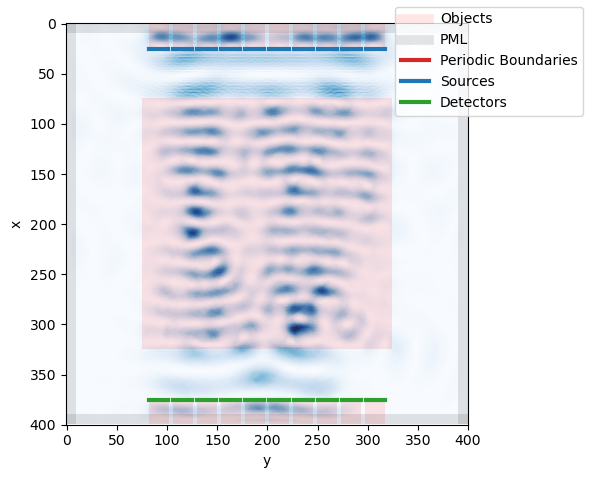

In [7]:
grid = Init([0.5]*10)
grid = set_permittivity(grid, np.random.rand(10, 10))
grid.run(total_time=1000)
grid.visualize(z=0)
print(grid.detectors[0].detector_values())  

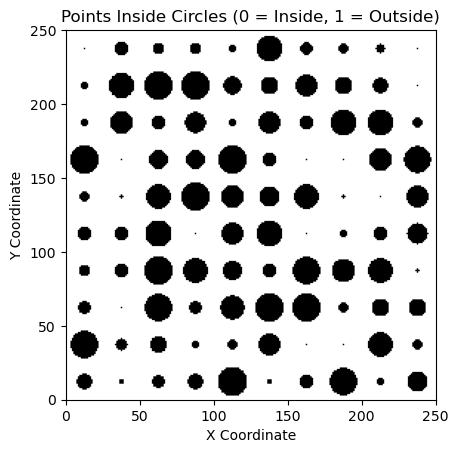

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def calculate_circle_grid(radius_matrix: np.ndarray) -> torch.Tensor:
    """
    Calculate a grid where each point is marked if it is inside any of the circles.

    The radius of the circles is scaled from 0 to 10.

    Parameters
    ----------
    radius_matrix : np.ndarray
        A 10x10 matrix representing the radii of the circles.

    Returns
    -------
    torch.Tensor
        A 250x250 tensor with 1s for points outside any circles and 0s for points inside circles.
    """
    # Scale the radius matrix to the range 0 to 10
    radius_matrix = torch.tensor(radius_matrix * 10)

    # Define the grid size and circle parameters
    grid_size = 250
    circle_count = 10
    spacing = 25  # Spacing between circle centers
    border_spacing = 12  # Starting position for the first circle center

    # Calculate the coordinates of the circle centers
    x_centers, y_centers = torch.meshgrid(
        torch.arange(border_spacing, grid_size, spacing),
        torch.arange(border_spacing, grid_size, spacing),
        indexing='ij'
    )
    x_centers = x_centers.flatten()
    y_centers = y_centers.flatten()

    # Create a grid containing all points' x and y coordinates
    x, y = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size), indexing='ij')

    # Create a new grid, marking each point as inside (0) or outside (1) a circle
    inside_grid = torch.ones((grid_size, grid_size), dtype=torch.int)

    # For each circle, calculate its affected area
    for i in range(circle_count * circle_count):
        cx, cy = x_centers[i], y_centers[i]
        radius = radius_matrix.flatten()[i]
        
        # Update the inside_grid using broadcasting
        mask = (x - cx) ** 2 + (y - cy) ** 2 <= radius ** 2
        inside_grid[mask] = 0

    return inside_grid

# Example usage
radius_matrix = np.random.rand(10, 10)  # Randomly generate a 10x10 radius matrix
result = calculate_circle_grid(radius_matrix)

# Plotting the result
plt.imshow(result.numpy(), cmap='gray', extent=[0, 250, 0, 250])
plt.title('Points Inside Circles (0 = Inside, 1 = Outside)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.show()

In [1]:
import torch
from model.student_model import data_expand

print(data_expand(torch.tensor([1, 2, 3]), 5))

tensor([[[0.0066, 0.0133, 0.0199],
         [0.1942, 0.3885, 0.5827],
         [0.5983, 1.1965, 1.7948],
         [0.1942, 0.3885, 0.5827],
         [0.0066, 0.0133, 0.0199]]])
